In [57]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [58]:
# Import dataset
df = pd.read_csv("./dataset.csv")

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]

# Identify numeric features to scale
numeric_features = [
    # "duration_ms",
    # "popularity",
    # "tempo",
    # "loudness",
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
]

numeric_high_value_features = [
    "popularity",
    "tempo",
    "loudness",
]

# All other features (binary or one-hot) are left as-is
non_scaled_features = [
    col 
    for col in X.columns 
    if col not in (numeric_features + numeric_high_value_features)
]
# non_scaled_features = [col for col in X.columns if col not in numeric_high_value_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", StandardScaler(), numeric_features),
        ("num", "passthrough", numeric_features),
        ("num2", MinMaxScaler(), numeric_high_value_features),
        ("pass", "passthrough", non_scaled_features),
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
final_features = numeric_features + numeric_high_value_features + non_scaled_features
X_processed = pd.DataFrame(X_processed, columns=final_features)
# X_processed = X_processed.apply(pd.to_numeric)  # <-- this line fixes your problem

# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

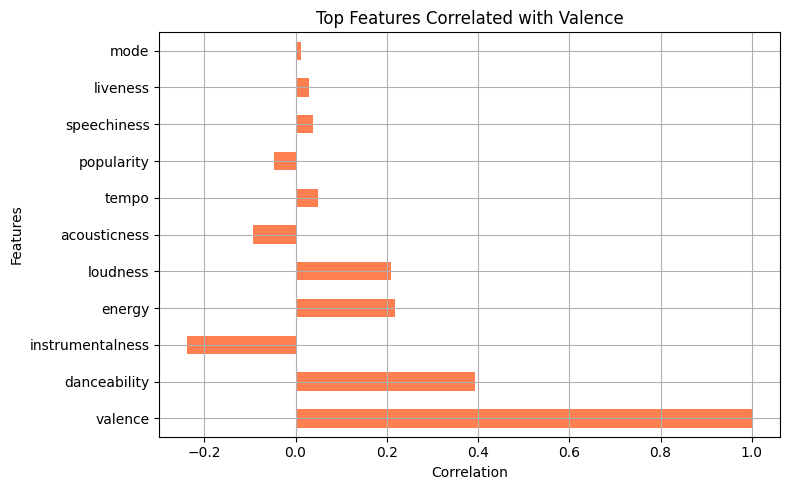

In [59]:
### Features correlating with Valence ###
# df = pd.read_csv("./dataset.csv")

corr_df = df.drop(
    columns=["track_id", "artists", "album_name", "track_name", "duration_ms", "explicit"],
    errors="ignore",
)
numeric_df = corr_df.select_dtypes(include="number")

corr_matrix = numeric_df.corr()["valence"]

# Get top 10 positively or negatively correlated features
top_valence_corr = corr_matrix.abs().sort_values(ascending=False).head(20)
top_valence_corr = corr_matrix[top_valence_corr.index]  # preserve sign

# Plot bar chart
plt.figure(figsize=(8, 5))
top_valence_corr.plot(kind="barh", color="coral")
plt.title("Top Features Correlated with Valence")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

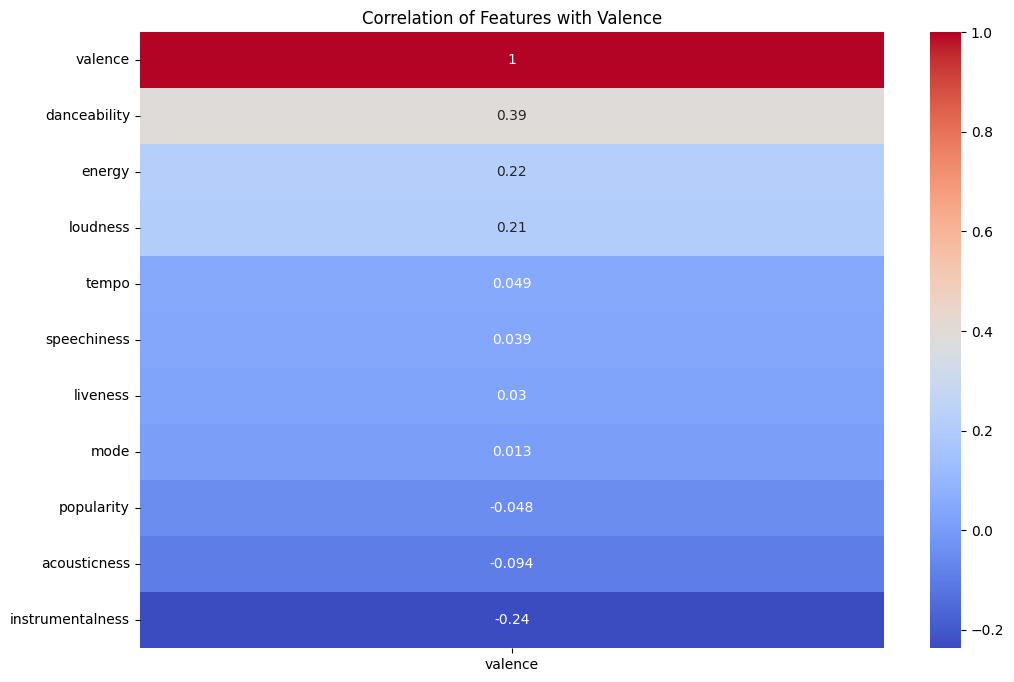

In [60]:
# Remove non-numeric columns
numeric_df = df.select_dtypes(include="number")
numeric_df = numeric_df.drop(columns=["duration_ms", "explicit"])

# Correlation matrix
corr = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr[["valence"]].sort_values(by="valence", ascending=False),
    annot=True,
    cmap="coolwarm",
)
plt.title("Correlation of Features with Valence")
plt.show()

In [61]:
# Check Outlier percentages of each feature
def calculate_outlier_percentage(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_percentage = len(outliers) / len(df) * 100
    return outlier_percentage

outlier_percentages = {}

for col in numeric_features + numeric_high_value_features:
    percent = calculate_outlier_percentage(df, col)
    outlier_percentages[col] = percent

# Show nicely
import pandas as pd
outlier_df = pd.DataFrame(list(outlier_percentages.items()), columns=["Feature", "Outlier_Percentage"])
print(outlier_df.sort_values(by="Outlier_Percentage", ascending=False))


            Feature  Outlier_Percentage
4  instrumentalness           22.145808
2       speechiness           11.588698
5          liveness            7.580768
8          loudness            5.414960
0      danceability            0.543864
7             tempo            0.541233
6        popularity            0.001754
3      acousticness            0.000000
1            energy            0.000000


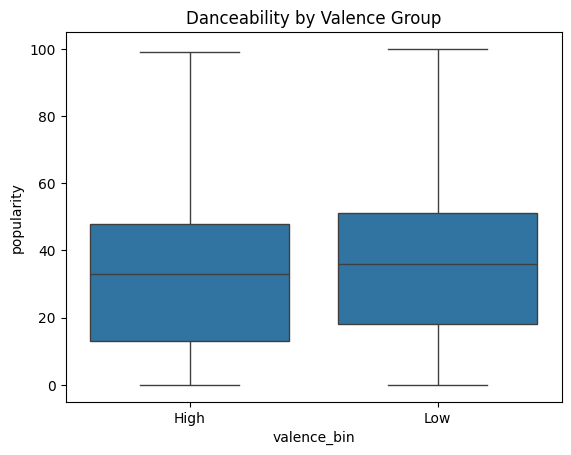

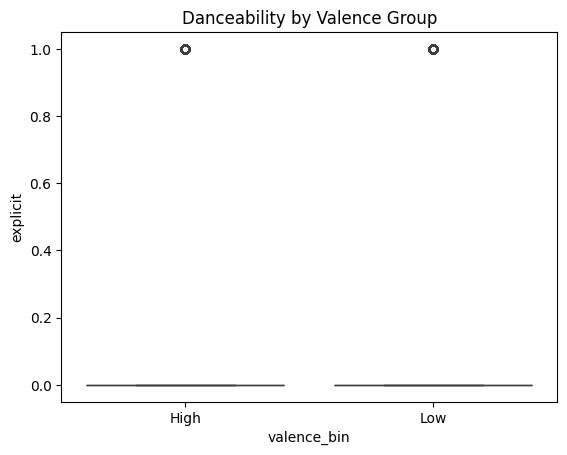

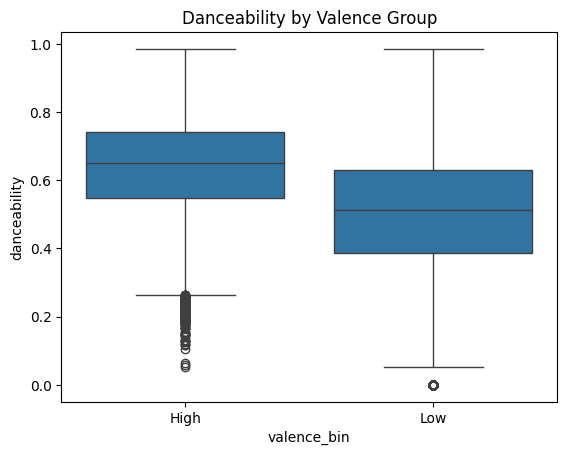

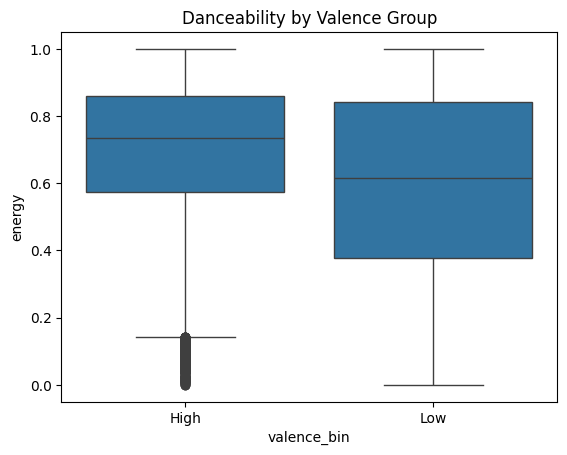

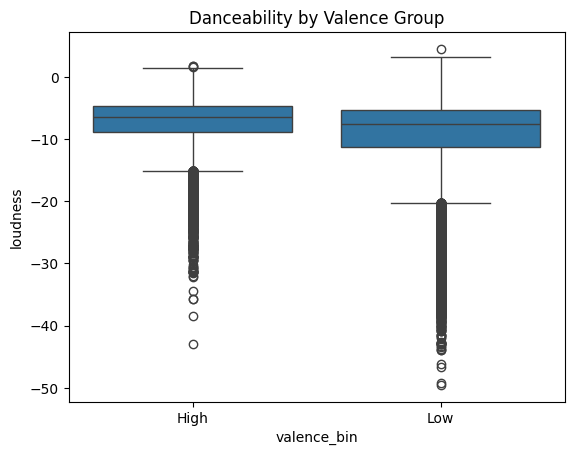

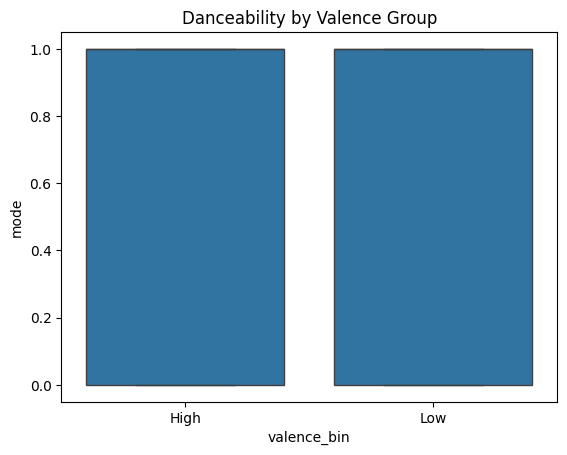

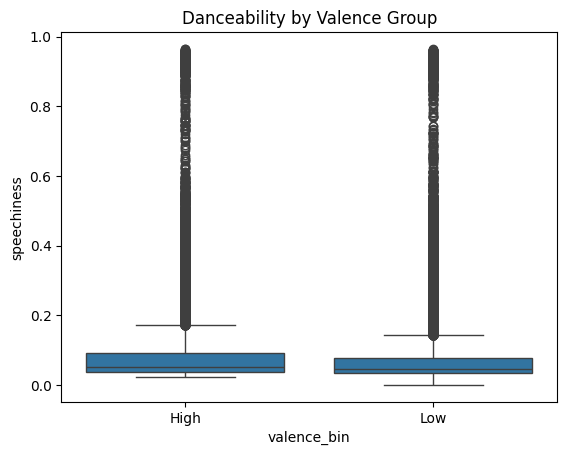

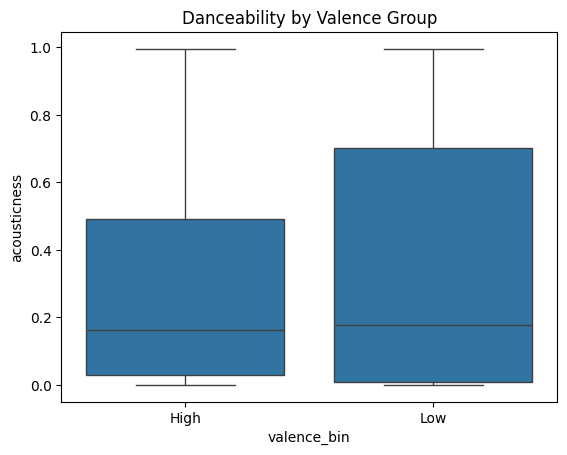

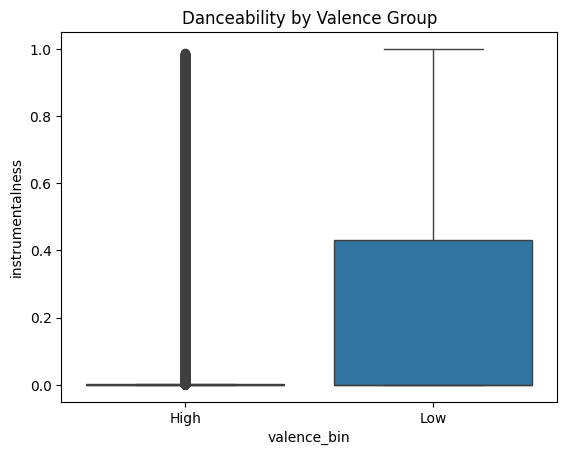

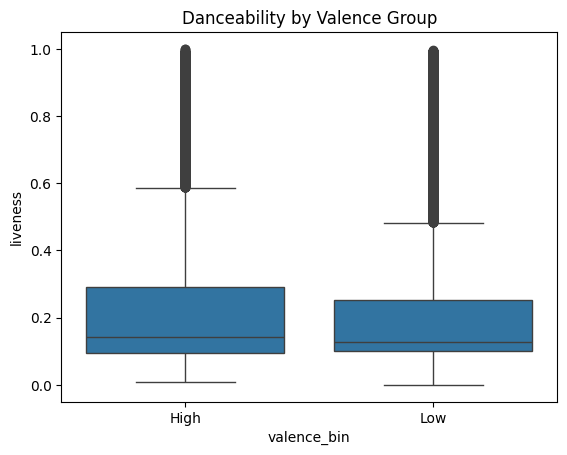

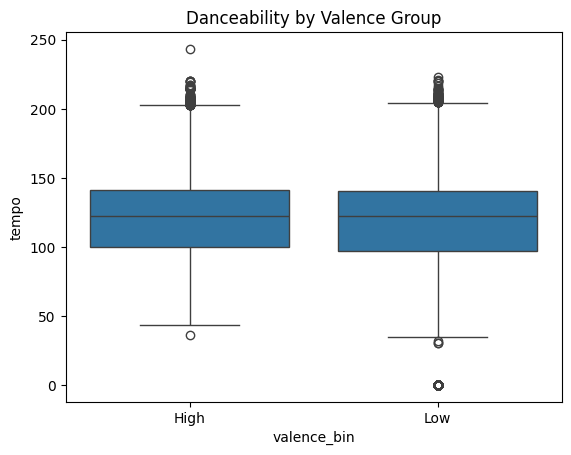

In [62]:
df["valence_bin"] = df["valence"].apply(lambda x: "High" if x > 0.5 else "Low")

for col in df.select_dtypes(include=["float", "int"]).columns:
    if col == "valence" or col == "duration_ms" or col == "valence_bin": continue

    sns.boxplot(x="valence_bin", y=f"{col}", data=df)
    plt.title("Danceability by Valence Group")
    plt.show()

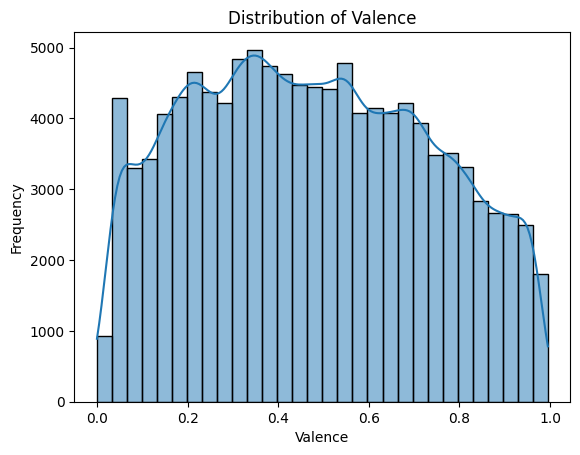

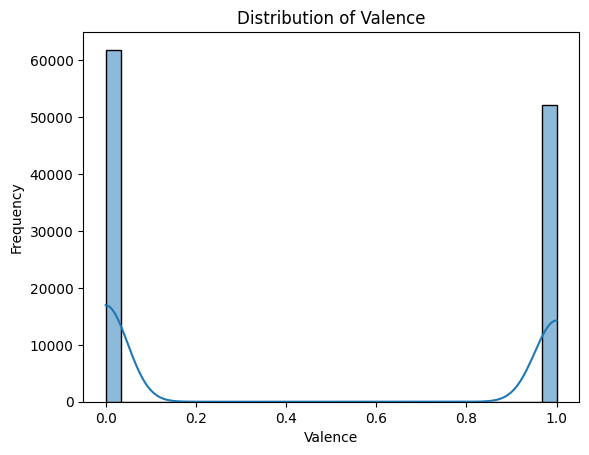

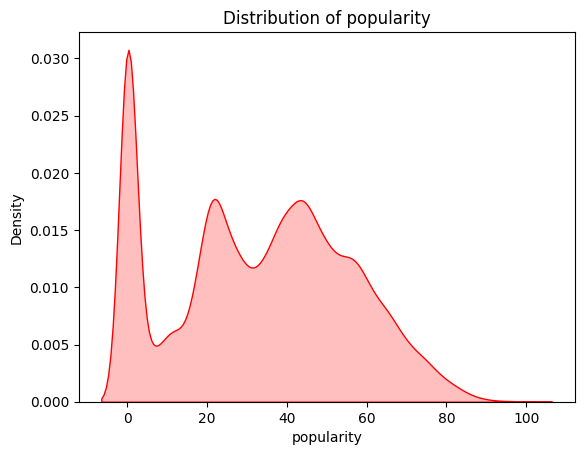

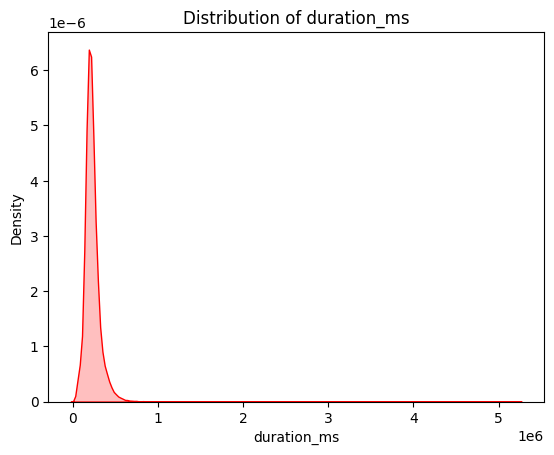

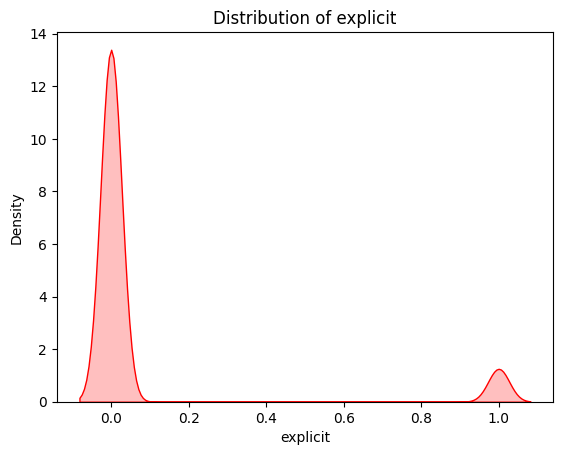

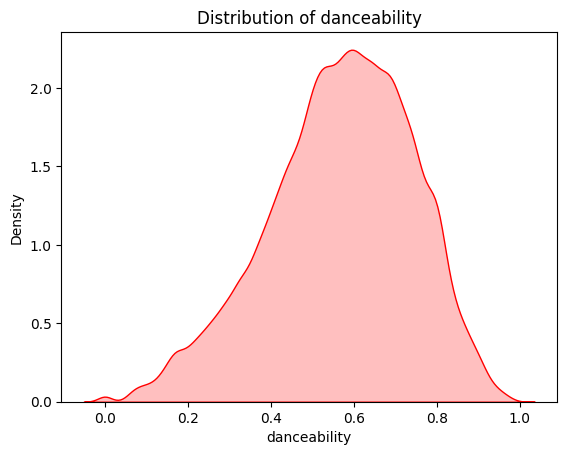

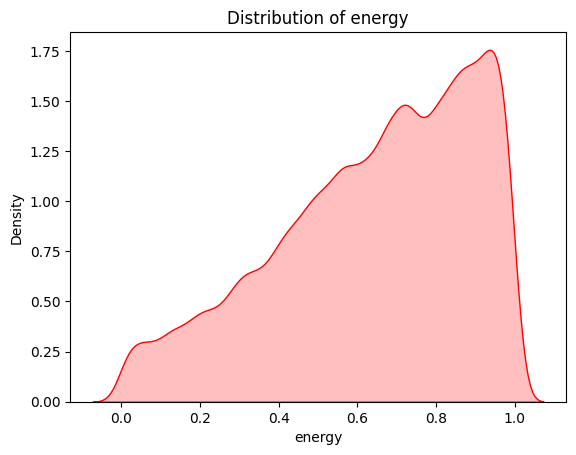

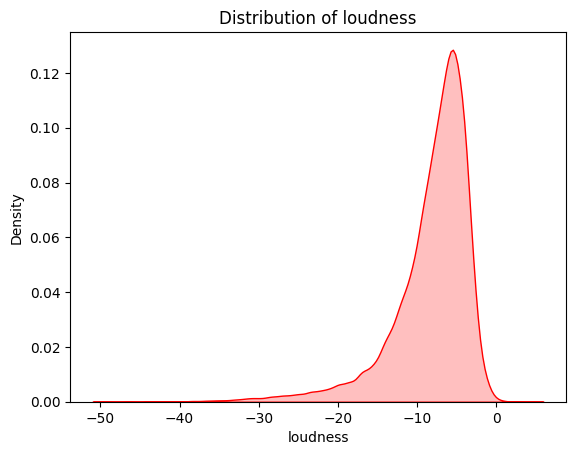

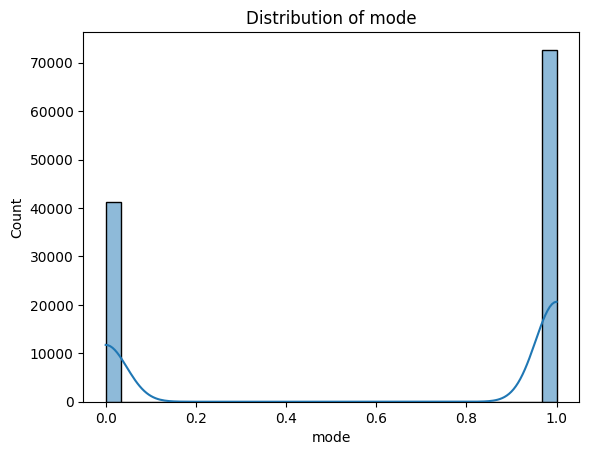

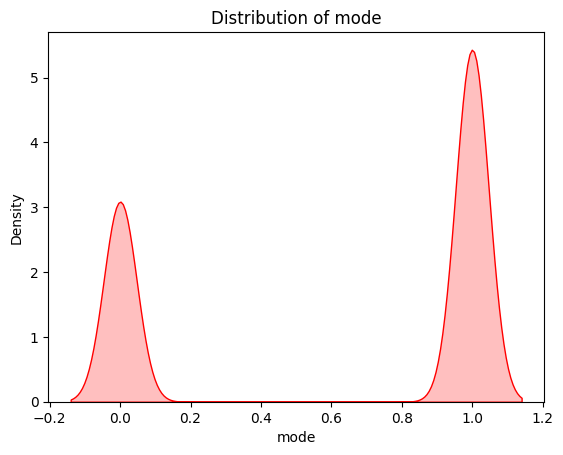

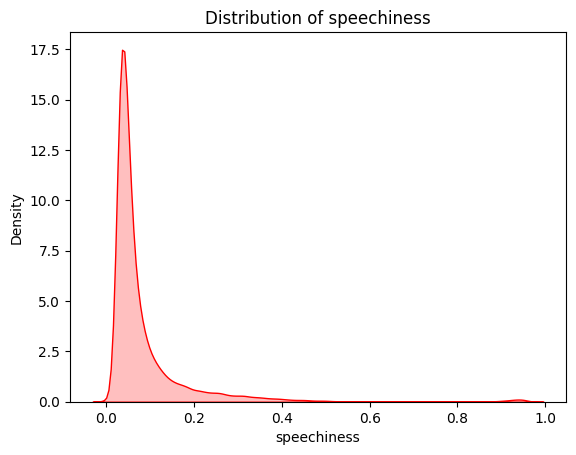

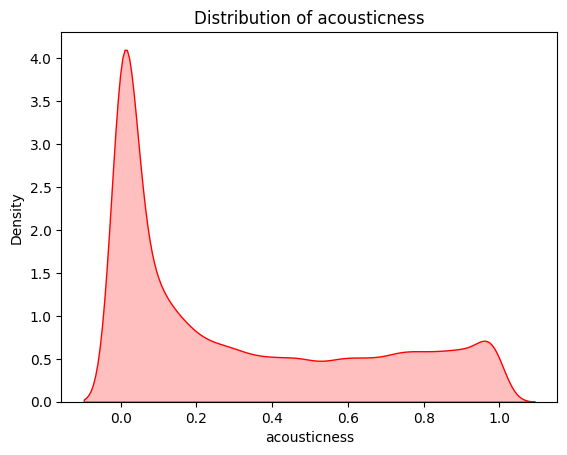

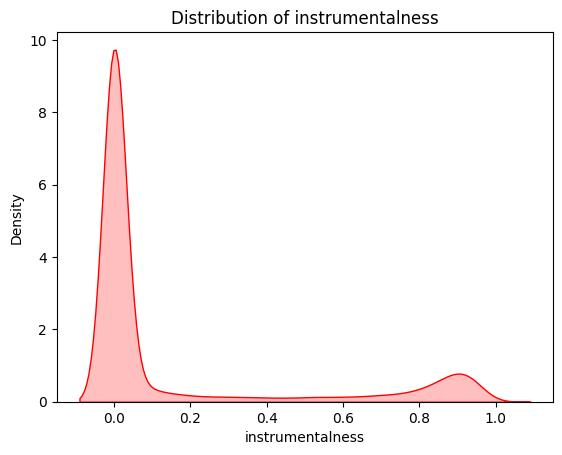

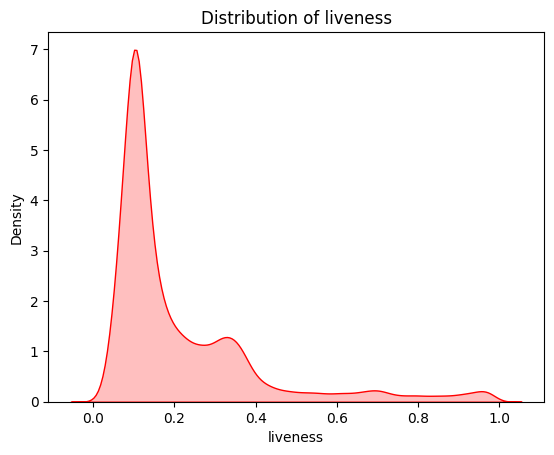

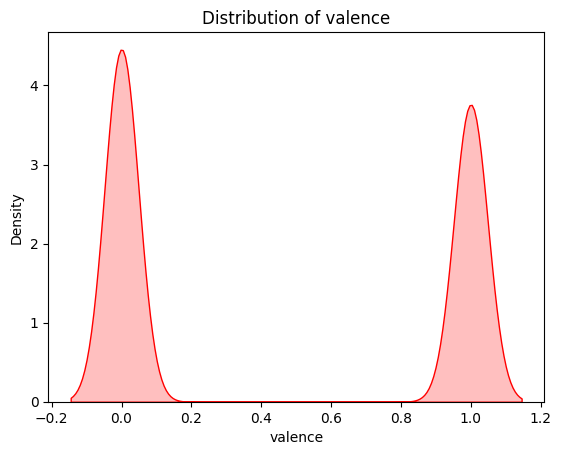

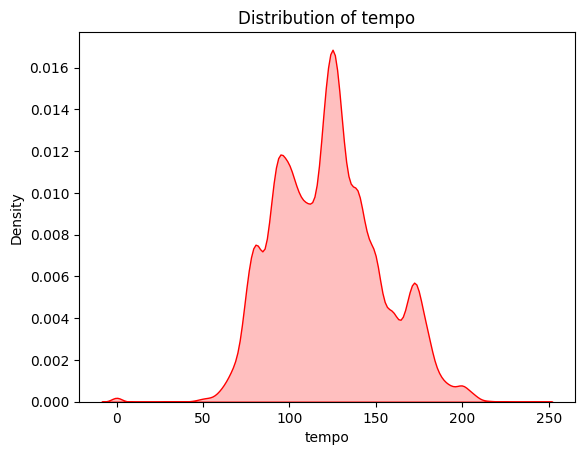

In [63]:
sns.histplot(df_original["valence"], kde=True, bins=30)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df["valence"], kde=True, bins=30)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Frequency")
plt.show()

for col in df.select_dtypes(include=["float", "int"]).columns:
    if col == "mode":
        mode_bar = df["mode"].apply(lambda x: "High" if x > 0.5 else "Low")
        sns.histplot(df["mode"], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.show()

    sns.kdeplot(df[col], label=f"{col}", fill=True, color="r")
    plt.title(f"Distribution of {col}")

    plt.show()


In [81]:
# Step 1: Find all genre columns
genre_columns = [col for col in df.columns if col.startswith('track_genre_')]

# Step 2: For each genre, calculate the average popularity
genre_popularity = {}
genre_counts = {}

for genre_col in genre_columns:
    # Only consider rows where this genre is active (value == 1)
    genre_name = genre_col.replace('track_genre_', '')  # clean the name
    
    genre_avg_popularity = df.loc[df[genre_col] == 1, 'popularity'].mean()
    count = df[genre_col].sum()  # sum of 1s = number of songs
    
    genre_counts[genre_name] = count
    genre_popularity[genre_name] = genre_avg_popularity

# Step 3: Convert to a DataFrame for easier sorting and plotting
genre_popularity = pd.Series(genre_popularity).sort_values(ascending=False)
genre_counts = pd.Series(genre_counts).sort_values(ascending=False)

# Display top genres
print(genre_popularity.head(10))
print(genre_counts.head(10))

# Export counts
# genre_popularity.to_csv("genres-sorted-by-popularity.csv", index=False)

# Top 10 genres
# top_genres = genre_popularity.head(10)
# plt.figure(figsize=(10, 5))
# sns.barplot(x=top_genres.index, y=top_genres.values)
# plt.xticks(rotation=45)
# plt.title('Top 10 Genres by Average Popularity')
# plt.xlabel('Genre')
# plt.ylabel('Average Popularity')
# plt.tight_layout()
# plt.show()


pop-film     59.283000
k-pop        56.952953
chill        53.651000
sad          52.379000
grunge       49.594000
indian       49.539000
anime        48.772000
emo          48.128000
sertanejo    47.866000
pop          47.576000
dtype: float64
afrobeat       1000
alt-rock       1000
alternative    1000
ambient        1000
anime          1000
black-metal    1000
bluegrass      1000
blues          1000
brazil         1000
breakbeat      1000
dtype: int64


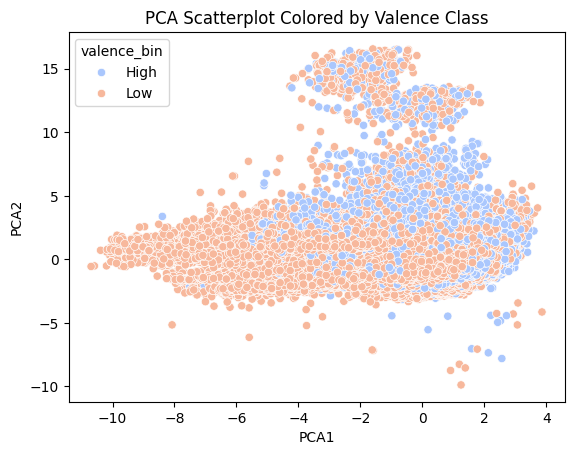

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = df.drop(
    columns=[
        "valence",
        "valence_bin",
        "track_id",
        "track_name",
        "artists",
        "album_name",
    ]
)
X_scaled = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

sns.scatterplot(x="PCA1", y="PCA2", hue="valence_bin", palette="coolwarm", data=df)
plt.title("PCA Scatterplot Colored by Valence Class")
plt.show()